# For an analysis competition...
What to predict?
- age ... too few nans (prediction may be meaningless...)
- cancellation of premium membership

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/cls_models/') 
from base_classifier import ClassifierBase
from lgb_classifier import LgbClassifier
from catb_classifier import CatbClassifier

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# Load data

In [2]:
!ls

EDA.ipynb            cls_models           reg_models
EDA_houseprice.ipynb code
EDA_laputa.ipynb     inputs


In [3]:
# check path
datapath = "inputs/"
datapath = "/Volumes/sec/anemos-poc-large-sec/users/kakawagu/data/laputa_comp"
files = os.listdir(datapath)
print(files)

['laputa.csv']


In [4]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/laputa.csv', index_col=0)
# test = pd.read_csv(datapath + '/test.csv')
# submission = pd.read_csv(datapath + '/sample_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

119.9589490890503  seconds to load data


In [5]:
# check train
print(train.shape)
train.head()

(10000, 1021)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,000081BEB28F85B6DE,2,NaN,20140518,20140525.0,20191201,37.0,67,289,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057251
1,0000DC88EA731D5BFC,1,NaN,20030216,20080701.0,20191201,38.0,202,876,False,...,NaN,NaN,NaN,NaN,0.022498,NaN,NaN,NaN,0.013953,0.002430
2,0000D9F6A83EA4C67C,2,NaN,20160424,20160426.0,20191130,38.0,44,188,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00088B68DFA836DEBE,1,NaN,20150111,20150116.0,20191119,28.0,59,255,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0007596AE753E853D9,1,NaN,20190901,20190905.0,20191104,23.0,3,13,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 1021 entries, y_id_hex to 99_yup_user_daily_score_2_interest_know_well_construction
dtypes: bool(6), float64(911), int64(17), object(87)
memory usage: 77.6+ MB


In [7]:
train.dtypes

y_id_hex                                                                           object
1_y_id_master_gender                                                                int64
1_y_id_master_birthday                                                            float64
1_y_id_master_registration_date                                                     int64
1_y_id_master_first_update                                                        float64
1_y_id_master_last_update                                                           int64
1_y_id_master_age                                                                 float64
1_y_id_master_registration_month                                                    int64
1_y_id_master_registration_week                                                     int64
1_y_id_master_chkyj_flag                                                             bool
2_user_profile_master_commerce_registration_month                                   int64
2_user_pro

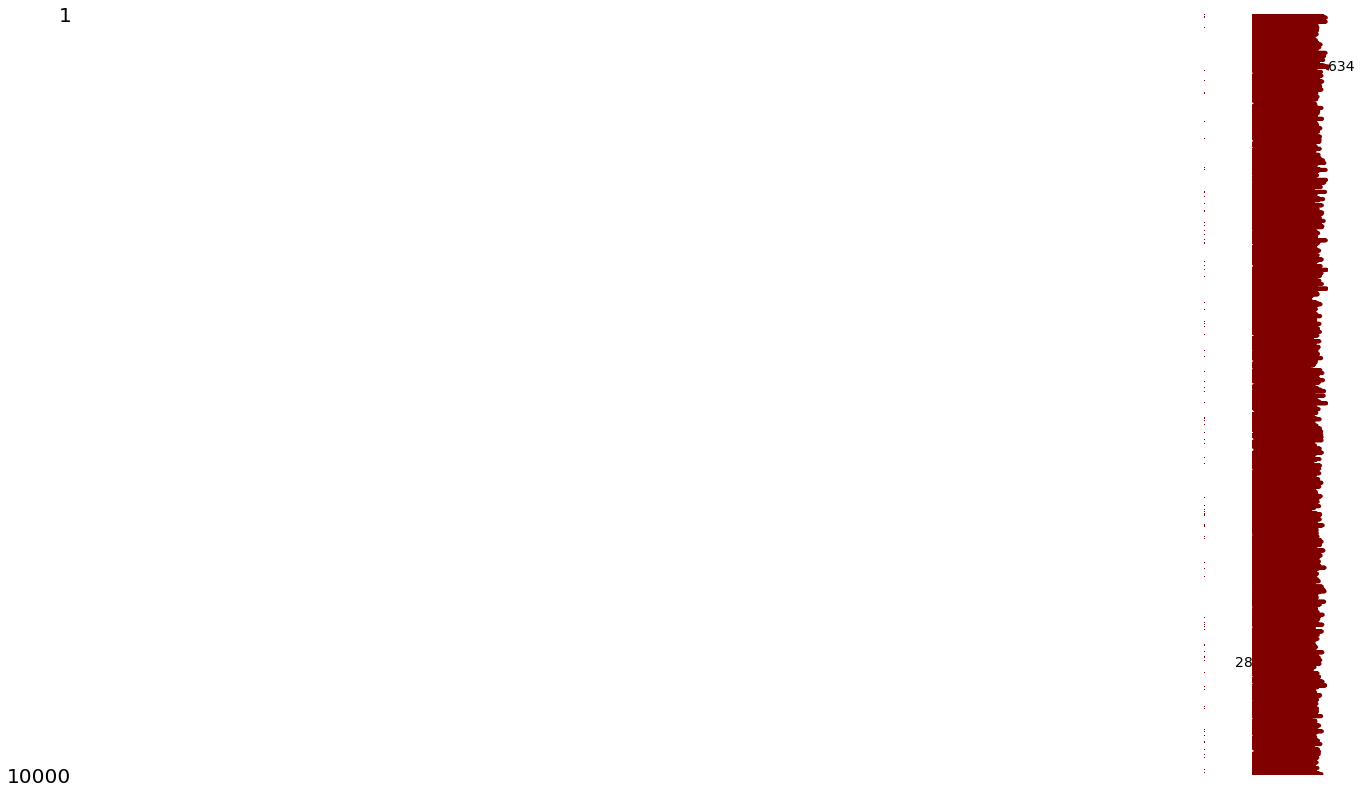

In [8]:
# missing data?
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [9]:
premium_features = []
for f in train.columns.values.tolist():
    if "premium_user_master" in f:
        premium_features.append(f)
        print(f)

10_premium_user_master_last_order_date
10_premium_user_master_premium_segment_id
10_premium_user_master_service_code
10_premium_user_master_channel_id
10_premium_user_master_campaign_id
10_premium_user_master_discount_id
10_premium_user_master_cancel_flag
10_premium_user_master_cancel_date
10_premium_user_master_cancel_type
10_premium_user_master_registration_day
10_premium_user_master_registration_month
10_premium_user_master_sbm_type
10_premium_user_master_first_order_date
10_premium_user_master_order_count


In [10]:
train[premium_features].head()

,10_premium_user_master_last_order_date,10_premium_user_master_premium_segment_id,10_premium_user_master_service_code,10_premium_user_master_channel_id,10_premium_user_master_campaign_id,10_premium_user_master_discount_id,10_premium_user_master_cancel_flag,10_premium_user_master_cancel_date,10_premium_user_master_cancel_type,10_premium_user_master_registration_day,10_premium_user_master_registration_month,10_premium_user_master_sbm_type,10_premium_user_master_first_order_date,10_premium_user_master_order_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190326.0,2.0,2432.0,C0ymb001,A-140601,800000924.0,False,NaN,NaN,297.0,9.0,0.0,20030707.0,6.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20170601.0,1.0,2419.0,NaN,NaN,800001066.0,True,20180420.0,2.0,0.0,0.0,5.0,20170601.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train["10_premium_user_master_cancel_flag"].dtype

dtype('O')

In [12]:
train["1_y_id_master_age"].isna().sum() / train.shape[0]

0.0218

# Target

In [13]:
# remove nan from target
target = "10_premium_user_master_cancel_flag"
# target = "1_y_id_master_age"
train = train.loc[train[target].isna().values == False, :].reset_index(drop=True, inplace=False)

train[target].value_counts()

38.0    306
46.0    269
51.0    251
44.0    245
45.0    242
43.0    240
28.0    235
47.0    228
32.0    228
48.0    228
42.0    227
39.0    226
40.0    224
41.0    222
34.0    220
50.0    219
37.0    218
49.0    212
33.0    209
36.0    209
35.0    202
30.0    197
29.0    191
23.0    187
55.0    177
53.0    171
27.0    166
31.0    166
54.0    166
24.0    163
22.0    163
20.0    160
25.0    152
26.0    151
21.0    150
52.0    148
19.0    146
56.0    145
60.0    143
57.0    136
59.0    135
18.0    132
58.0    132
61.0    109
63.0    104
17.0     95
62.0     95
64.0     91
66.0     90
16.0     84
65.0     83
69.0     75
68.0     68
15.0     68
67.0     64
70.0     58
72.0     53
71.0     45
14.0     39
13.0     27
75.0     26
76.0     25
73.0     24
74.0     19
12.0     16
77.0     15
78.0     12
79.0     10
82.0      8
80.0      7
11.0      6
81.0      6
84.0      6
83.0      3
88.0      2
92.0      2
87.0      2
90.0      2
10.0      1
89.0      1
7.0       1
86.0      1
94.0      1
99.0

In [14]:
train[target] = train[target].astype(int)
train[target].value_counts()

38    306
46    269
51    251
44    245
45    242
43    240
28    235
48    228
32    228
47    228
42    227
39    226
40    224
41    222
34    220
50    219
37    218
49    212
33    209
36    209
35    202
30    197
29    191
23    187
55    177
53    171
27    166
54    166
31    166
22    163
24    163
20    160
25    152
26    151
21    150
52    148
19    146
56    145
60    143
57    136
59    135
58    132
18    132
61    109
63    104
17     95
62     95
64     91
66     90
16     84
65     83
69     75
15     68
68     68
67     64
70     58
72     53
71     45
14     39
13     27
75     26
76     25
73     24
74     19
12     16
77     15
78     12
79     10
82      8
80      7
81      6
84      6
11      6
83      3
87      2
88      2
90      2
92      2
89      1
10      1
86      1
94      1
7       1
99      1
Name: 1_y_id_master_age, dtype: int64

In [15]:
# hist
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x=target, data=train, ax=ax)
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_title("nnans = {}, {}%".format(train[target].isna().sum(), 100 * train[target].isna().sum() / train.shape[0]))
ax.set_xlabel(target)
ax.set_ylabel("#")

In [16]:
# roughly categorize features
cat_features = []
dense_features = []
for f in train.columns.values.tolist():
    if f != target:
        if (train[f].dtype == "object") | (train[f].dtype == "bool"):
            cat_features.append(f)
        else:
            dense_features.append(f)
features = dense_features + cat_features
print(f"There are {len(features)} features.")
print(f"There are {len(dense_features)} dense features.")
print(f"There are {len(cat_features)} categorical features.")

There are 1020 features.
There are 927 dense features.
There are 93 categorical features.


# Train, test split

In [17]:
kf = StratifiedKFold(n_splits=5, random_state=1220, shuffle=True)
for fold, (train_index, test_index) in enumerate(kf.split(train, train[target].values)):
    if fold == 0:
        X_train, X_test = train.loc[train_index, :], train.loc[test_index, :]
        y_train, y_test = train.loc[train_index, target], train.loc[test_index, target]
    else:
        pass

In [18]:
print(X_train.shape)
X_train.head()

(7791, 1021)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,000081BEB28F85B6DE,2,NaN,20140518,20140525.0,20191201,37,67,289,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057251
1,0000DC88EA731D5BFC,1,NaN,20030216,20080701.0,20191201,38,202,876,False,...,NaN,NaN,NaN,NaN,0.022498,NaN,NaN,NaN,0.013953,0.002430
2,0000D9F6A83EA4C67C,2,NaN,20160424,20160426.0,20191130,38,44,188,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00088B68DFA836DEBE,1,NaN,20150111,20150116.0,20191119,28,59,255,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0007596AE753E853D9,1,NaN,20190901,20190905.0,20191104,23,3,13,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
print(X_test.shape)
X_test.head()

(1991, 1021)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,1_y_id_master_chkyj_flag,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
7,00051063B11F67E0A8,1,NaN,20191124,20191126.0,20191126,67,1,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000D3889905E56648,1,NaN,20151227,20151230.0,20191201,34,48,205,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0000D2D266B1AA4C2D,2,NaN,20070204,20080713.0,20191201,34,154,669,False,...,0.004706,NaN,0.014743,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0000CFBA992DE7AB41,2,NaN,20170611,20170617.0,20191201,46,30,129,False,...,NaN,0.035332,NaN,NaN,NaN,0.006862,NaN,0.032296,NaN,NaN
18,00091C86D90D59DA0A,1,NaN,20070107,NaN,20191129,51,155,673,False,...,NaN,0.062812,NaN,NaN,NaN,NaN,0.006965,NaN,NaN,NaN


# Dense features

In [20]:
vd = DenseVisualizer(train=X_train, test=X_test, features=dense_features, target=target)
chkd = vd.column_checker()
print(chkd.shape)
chkd.head()

feature name = 1_y_id_master_gender
feature name = 1_y_id_master_birthday
feature name = 1_y_id_master_registration_date
feature name = 1_y_id_master_first_update
feature name = 1_y_id_master_last_update
feature name = 1_y_id_master_registration_month
feature name = 1_y_id_master_registration_week
feature name = 2_user_profile_master_commerce_registration_month
feature name = 2_user_profile_master_commerce_gender
feature name = 2_user_profile_master_commerce_age
feature name = 2_user_profile_master_commerce_tcard_status
feature name = 2_user_profile_master_commerce_preimum_registration_month
feature name = 2_user_profile_master_commerce_premium_segment_id
feature name = 2_user_profile_master_commerce_wallet_registration_month
feature name = 2_user_profile_master_commerce_shopping_order_count
feature name = 2_user_profile_master_commerce_shopping_avg_total_price
feature name = 2_user_profile_master_commerce_shopping_avg_order_day
feature name = 2_user_profile_master_commerce_shopping_la

feature name = 8_app_user_monthly_stats_npb_textlive_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_maps_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_sportsnavi_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_ymobile_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_ysmartsecurity_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_yjcal_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_yfiler_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_apps_map_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_apps_navi_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_finance_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_ybackup_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_chiebukuro_first_activate_date_monthly
feature name = 8_app_user_monthly_stats_yqrcode_first_activate_date_month

feature name = 8_app_user_monthly_stats_mail_activate_day
feature name = 8_app_user_monthly_stats_yjtrend_activate_day
feature name = 8_app_user_monthly_stats_apppkgcal_activate_day
feature name = 8_app_user_monthly_stats_ymail_activate_day
feature name = 8_app_user_monthly_stats_emg_activate_day
feature name = 8_app_user_monthly_stats_ysmarttool_activate_day
feature name = 8_app_user_monthly_stats_ybrowser_activate_day
feature name = 8_app_user_monthly_stats_ynaviapp_activate_day
feature name = 8_app_user_monthly_stats_npb_textlive_activate_day
feature name = 8_app_user_monthly_stats_maps_activate_day
feature name = 8_app_user_monthly_stats_sportsnavi_activate_day
feature name = 8_app_user_monthly_stats_ymobile_activate_day
feature name = 8_app_user_monthly_stats_ysmartsecurity_activate_day
feature name = 8_app_user_monthly_stats_yjcal_activate_day
feature name = 8_app_user_monthly_stats_yfiler_activate_day
feature name = 8_app_user_monthly_stats_apps_map_activate_day
feature name = 8

feature name = 8_app_user_monthly_stats_auctions_duration
feature name = 8_app_user_monthly_stats_mail_duration
feature name = 8_app_user_monthly_stats_yjtrend_duration
feature name = 8_app_user_monthly_stats_apppkgcal_duration
feature name = 8_app_user_monthly_stats_ymail_duration
feature name = 8_app_user_monthly_stats_emg_duration
feature name = 8_app_user_monthly_stats_ysmarttool_duration
feature name = 8_app_user_monthly_stats_ybrowser_duration
feature name = 8_app_user_monthly_stats_ynaviapp_duration
feature name = 8_app_user_monthly_stats_npb_textlive_duration
feature name = 8_app_user_monthly_stats_maps_duration
feature name = 8_app_user_monthly_stats_sportsnavi_duration
feature name = 8_app_user_monthly_stats_ymobile_duration
feature name = 8_app_user_monthly_stats_ysmartsecurity_duration
feature name = 8_app_user_monthly_stats_yjcal_duration
feature name = 8_app_user_monthly_stats_yfiler_duration
feature name = 8_app_user_monthly_stats_apps_map_duration
feature name = 8_app_u

feature name = 8_app_user_monthly_stats_yfiler_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_apps_map_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_apps_navi_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_finance_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_ybackup_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_chiebukuro_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_yqrcode_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_launcher_buzzhome_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_ebookjapan_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_pmall_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_ymsetupman_last_widget_activate_date_monthly
feature name = 8_app_user_monthly_stats_realtime_buzzalert_last_widget_activate

feature name = 25_ycard_apply_info_job_code
feature name = 25_ycard_apply_info_business_code
feature name = 25_ycard_apply_info_driver_license_type
feature name = 25_ycard_apply_info_household_num
feature name = 25_ycard_apply_info_purpose_type
feature name = 25_ycard_apply_info_rank1
feature name = 25_ycard_apply_info_rank6
feature name = 25_ycard_apply_info_rank7
feature name = 25_ycard_apply_info_rank8
feature name = 25_ycard_apply_info_rank9
feature name = 99_yup_user_daily_score_attribute_residence_urban
feature name = 99_yup_user_daily_score_attribute_homemaker
feature name = 99_yup_user_daily_score_attribute_engineer
feature name = 99_yup_user_daily_score_attribute_family_baby
feature name = 99_yup_user_daily_score_attribute_family_infant
feature name = 99_yup_user_daily_score_attribute_property_glasses
feature name = 99_yup_user_daily_score_attribute_property_bicycle
feature name = 99_yup_user_daily_score_attribute_property_car
feature name = 99_yup_user_daily_score_attribute_s

feature name = 99_yup_user_daily_score_attribute_use_iphone
feature name = 99_yup_user_daily_score_attribute_use_android
feature name = 99_yup_user_daily_score_attribute_use_contact_lense
feature name = 99_yup_user_daily_score_attribute_use_hearing_aid
feature name = 99_yup_user_daily_score_attribute_use_rental_car
feature name = 99_yup_user_daily_score_interest_anime_song
feature name = 99_yup_user_daily_score_interest_japan_baseball
feature name = 99_yup_user_daily_score_interest_mlb
feature name = 99_yup_user_daily_score_interest_highschool_baseball
feature name = 99_yup_user_daily_score_interest_j_league
feature name = 99_yup_user_daily_score_interest_world_football
feature name = 99_yup_user_daily_score_interest_horse_racing
feature name = 99_yup_user_daily_score_2_interest_golf
feature name = 99_yup_user_daily_score_2_interest_figure_skating
feature name = 99_yup_user_daily_score_2_interest_f1
feature name = 99_yup_user_daily_score_2_interest_tennis
feature name = 99_yup_user_dai

feature name = 99_yup_user_daily_score_2_interest_know_well_construction
(927, 13)


,features,train_nans,test_nans,train_nunique,test_nunique,train_min,test_min,train_max,test_max,train_mean,test_mean,train_skew,test_skew
0,1_y_id_master_gender,0,0,3,3,0.0,0.0,2.0,2.0,1.388910e+00,1.386740e+00,-0.064124,-0.157439
1,1_y_id_master_birthday,7791,1991,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1_y_id_master_registration_date,0,0,1039,782,19980726.0,19980726.0,20191124.0,20191124.0,2.013288e+07,2.013298e+07,-0.800638,-0.825144
3,1_y_id_master_first_update,253,71,2750,1198,20080629.0,20080629.0,20191201.0,20191201.0,2.014368e+07,2.014402e+07,-0.459049,-0.455991
4,1_y_id_master_last_update,0,0,31,31,20191101.0,20191101.0,20191201.0,20191201.0,2.019118e+07,2.019118e+07,-0.787068,-0.869722


In [ ]:
chkd.style.background_gradient()

In [ ]:
# remove features with too many nans
dense_features = chkd.loc[chkd["train_nans"] < 1000, "features"].values.tolist()
print(dense_features)

# Categorical features

In [ ]:
# EDA for categorical features
vc = CategoricalVisualizer(train=X_train, test=X_test, features=cat_features, target=target)
chkc = vc.column_checker()
print(chkc.shape)
chkc.head()

In [ ]:
chkc.style.background_gradient()

In [ ]:
# remove features with too many nans
cat_features = chkc.loc[chkc["train_nans"] < 1000, "features"].values.tolist()
print(cat_features)

# Fit LGB and Get Feature importance

In [ ]:
for f in features:
    if X_train[f].dtype == "bool":
        X_train[f] = X_train[f].astype(int)
        X_test[f] = X_test[f].astype(int)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

In [ ]:
# label encoding object features
train, test = label_encoding(X_train, X_test, cat_features)
train.head()

In [ ]:
train[target].isna().sum()

In [ ]:
test[target].isna().sum()

In [ ]:
features = dense_features + cat_features
target in features

In [ ]:
# fit LGB
lgbcls = LgbRegressor(train, test, target, features, categoricals=cat_features, cv_method="StratifiedKFold")

In [ ]:
# plot feature importance
lgbcls.plot_feature_importance(rank_range=[1,100])